In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf



In [2]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

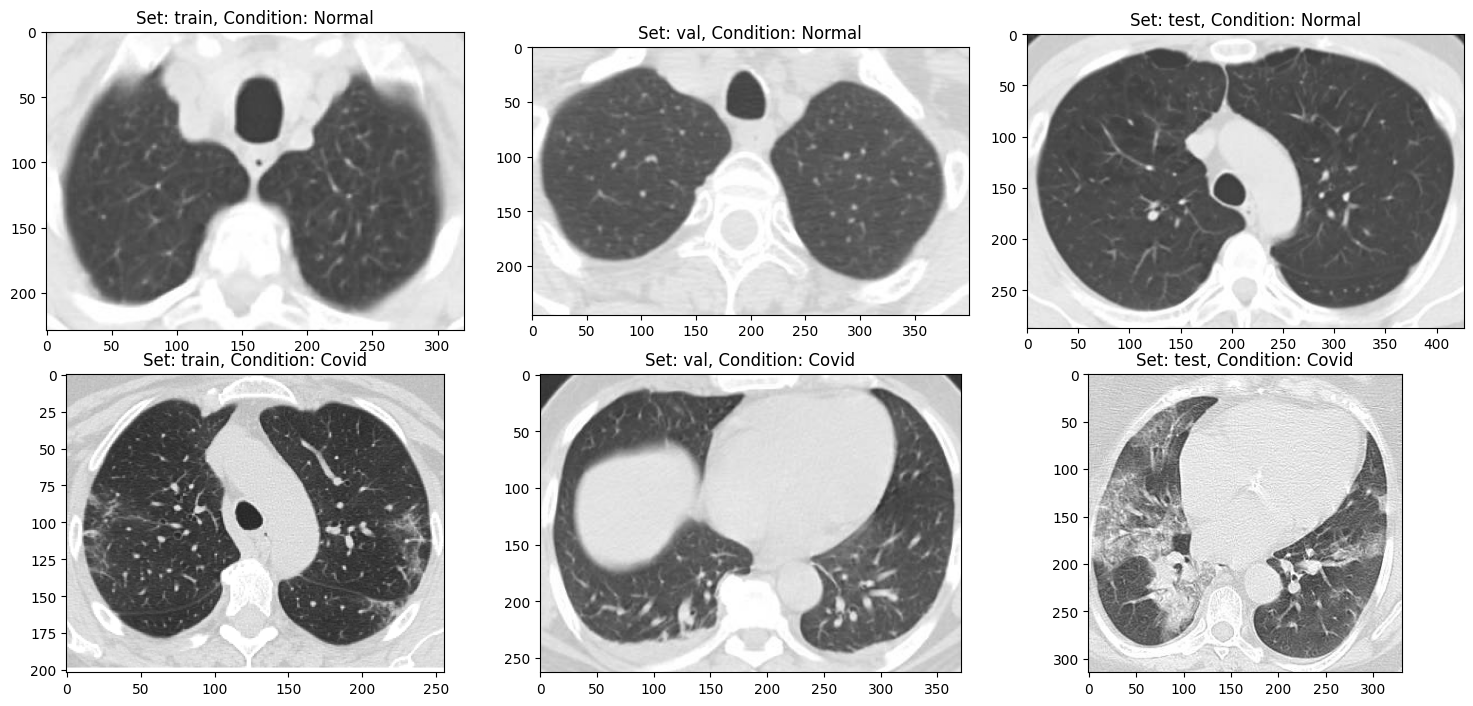

In [3]:
#input the path to your dataset in your local computer
input_path = '../Covid-19-Prediction/Covid_CT/'

# Display images
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

#we have 3 sets of data 'train', 'test', 'val' each containing two folders 'COVID' and 'Normal'
for i, _set in enumerate(['train', 'val', 'test']):
    #the path that you have input + the name of the set (eg. Covid-19-Prediction/Covid_CT/ + train)
    set_path = input_path+_set
    #reading the path, finding the first image and display it
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    #adding title to your img
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/COVID/'+os.listdir(set_path+'/COVID')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Covid'.format(_set))


In [4]:
#let's find out how our data distributed

for _set in ['train','test', 'val']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL')) #Number of Normal cases in each set
    n_covid = len(os.listdir(input_path + _set + '/COVID')) #Number of infected cases in esch set
    
    print('set= {}, Number of Normal Images: {}, Number of Covid Images: {}'.format(_set, n_normal, n_covid))

set= train, Number of Normal Images: 992, Number of Covid Images: 993
set= test, Number of Normal Images: 119, Number of Covid Images: 130
set= val, Number of Normal Images: 118, Number of Covid Images: 129


In [5]:

def process_data (img_dims, batch_size):
    #data generation objects: Keras ImageDataGenerator is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.
    train_data = ImageDataGenerator(rescale= 1./255, zoom_range= 0.3, vertical_flip= True) #rescale=1./255 will convert the pixels in range [0,255] to range [0,1].

    test_data = ImageDataGenerator(rescale= 1./255)
    
    
    #flow_from_directory allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data.
    train_gen = train_data.flow_from_directory(
    directory= input_path+'train',
    target_size= (img_dims, img_dims),
    batch_size= batch_size,
    class_mode= 'binary',
    shuffle= True)
    
    test_val_gen = test_data.flow_from_directory(
    directory= input_path+'test',
    target_size= (img_dims, img_dims),
    batch_size= batch_size,
    class_mode= 'binary',
    shuffle= True)
    
    
    
    tst_data = []
    tst_label = []
    label = 0
    
    for folder in ['/NORMAL/', '/COVID/']:
        for img in (os.listdir(input_path+'test'+folder)):
            img = plt.imread(input_path+'test'+folder+img)
            img = cv2.resize(img, (img_dims,img_dims))
            img = np.dstack([img, img, img]) # to stack or arrange the given arrays in a sequence depth wise (that is, along the third axis), thereby creating an array of at least 3-D .
            img = img.astype('float32')/255
        
            if folder == "/NORMAL":
                label = 0
            elif folder == "/COVID/":
                label = 1
            
            tst_data.append(img)
            tst_label.append(label)
            
    tst_data = np.array(tst_data)
    tst_label = np.array(tst_label)
    
    return train_gen, test_val_gen, tst_data, tst_label
        
        
    

In [6]:
img_dims =150
epoch = 10
batch_size = 32

train_gen, test_val_gen, tst_data, tst_label = process_data(img_dims,batch_size)

Found 1985 images belonging to 2 classes.
Found 249 images belonging to 2 classes.


In [7]:
# Layers
#1 input layer

inputs = Input(shape=(img_dims,img_dims, 3))

#2 first conv block
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#3 second conv layer
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#4 third conv layer
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5 forth conv layer
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#6 fifth conv layer
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#7 FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)


#8 Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')



In [9]:
#now its time to fit the model

hist = model.fit_generator(
    train_gen, steps_per_epoch= train_gen.samples // batch_size,
    epochs= epoch, validation_data= test_val_gen,
    validation_steps= test_val_gen.samples // batch_size, callbacks= [checkpoint, lr_reduce])

C:\Users\DFR\AppData\Local\Temp\ipykernel_4592\465956465.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
62/62 [==============================] - 96s 1s/step - loss: 0.6667 - accuracy: 0.5678 - val_loss: 0.6942 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - 74s 1s/step - loss: 0.6164 - accuracy: 0.6651 - val_loss: 0.6924 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - 74s 1s/step - loss: 0.5782 - accuracy: 0.7025 - val_loss: 0.7415 - val_accuracy: 0.5223 - lr: 0.0010
Epoch 4/10
62/62 [==============================] - 74s 1s/step - loss: 0.5249 - accuracy: 0.7506 - val_loss: 0.6844 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/10
62/62 [==============================] - 73s 1s/step - loss: 0.5308 - accuracy: 0.7465 - val_loss: 0.7538 - val_accuracy: 0.5223 - lr: 0.0010
Epoch 6/10
62/62 [==============================] - 72s 1s/step - loss: 0.4885 - accuracy: 0.7762 - val_loss: 0.8317 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 7/10
62/62 [==============================] - 74s 1s/step - loss: 0.4807 - a

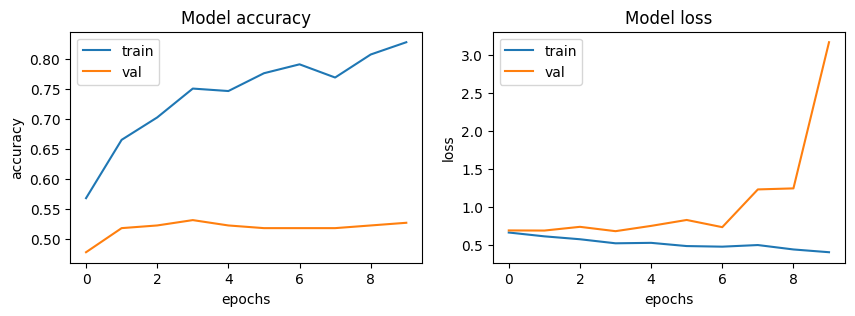

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])